# Unireps Hackathon: Aligning Neural Representations


# Unireps Hackathon: Aligning Neural Representations

The primary
 of this hackathon is to explore the **alignment of neural representations**. Specifically, we aim to investigate:

- **When, how and why** it is meaningful to align representations
- The potential **caveats**, such as:
  - Number of recorded cells
  - Neural remapping
  - Variability across experimental conditions

We will adapt methods originally developed for aligning representations in **machine learning** to neuroscience applications, focusing on **grid cell** activity.

The hackathon will use the **Neural Playground** platform as our main tool.

---

## 🧠 Steps Overview

### 1. Data Acquisition

We will first introduce these representation found int he entoriehnal coretex We will begin by using Neural Playground to access the **Sargolini dataset**, which includes:

- Animal trajectory data
- Corresponding grid cell recordings

### 2. Agent Training

We will build a arena based on the experiemtal imfroamtion and train an artificial agent using the **Stachenfeld successor representation (SR) model**, applying it to the same trajectory as in the experimental data. This will allow us to generate **comparable neural representations**.

### 3. Representation Comparison

To evaluate and compare biological and artificial representations, we will build **Representational Similarity Matrices (RSMs)**. These will help us quantify and visualize the alignment between the two systems.

---

Let us know what you'd like to explore further—whether it’s alignment techniques, specific neural metrics, or alternative agent models!

## 1. Data Acquisition

### 🧭 What is a Grid Cell?

**Grid cells** are a type of neuron found in the **medial entorhinal cortex** of the brain, first discovered in 2005 by **Hafting et al.** These cells are remarkable for their unique firing patterns: as an animal moves through its environment, a grid cell activates at multiple locations that form a **hexagonal grid-like pattern** across space.

This spatially periodic activity makes grid cells essential for **navigation** and **spatial memory**. Unlike place cells, which fire at specific locations, grid cells provide a **universal coordinate system** that can generalize across different environments.

Grid cells have become one of the most studied neural representations due to their:

- **Structured and regular firing patterns**
- **Role in path integration** (estimating position based on self-motion)
- **Relevance to models of cognitive mapping and spatial encoding**

Understanding grid cells has been crucial in bridging **neuroscience and computational models**, especially in exploring how the brain constructs internal maps of the external world.

In this hackathon, we focus on grid cells as a case study to investigate how **neural representations can be aligned** across biological and artificial systems.

### Sargolini et al 2006

We take the recoding from
- *Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex*, Sargolini et al 2006 (https://www.science.org/doi/10.1126/science.1125572)

In this experiment the rats freely moved in a 2D square environemt.
Bellow we plot the recorded cells.


In [46]:
from neuralplayground.experiments import Sargolini2006Data
import numpy as np


In [47]:
sargolini_data = Sargolini2006Data(verbose=True)

The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have  been published in 
Sargolini et al. (Science, 2006). 

The files are in matlab format. They include spike and position times for recorded cells from rats that were running in a 1 x 1 m
enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex. Position is given for two LEDs 
to enable calculation of head direction.

The cell id is based on tetrode number and cell number (i.e: t2c7).

The file naming convention is as follow:

Rat number - session number _ cell id (i.e: 11084-03020501_t2c1).

Each session duration is normally 10 minutes, but some sessions are combination of 2 or more 10 minutes sessions, this is marked in 
the file name by using "+" between the session numbers (i.e: 11207-21060501+02_t6c1). Note that the 6 first digits in the session 
number is the date of the recording.

When loading the files into Matlab you 

,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


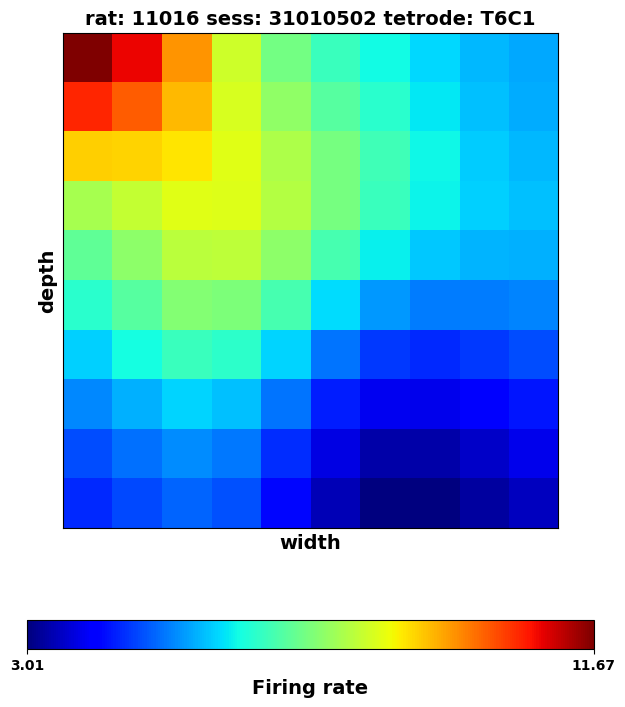

In [48]:
rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(save_path ='./trajectory_after_merge_2',recording_index=4, tetrode_id="T6C1",bin_size=10)

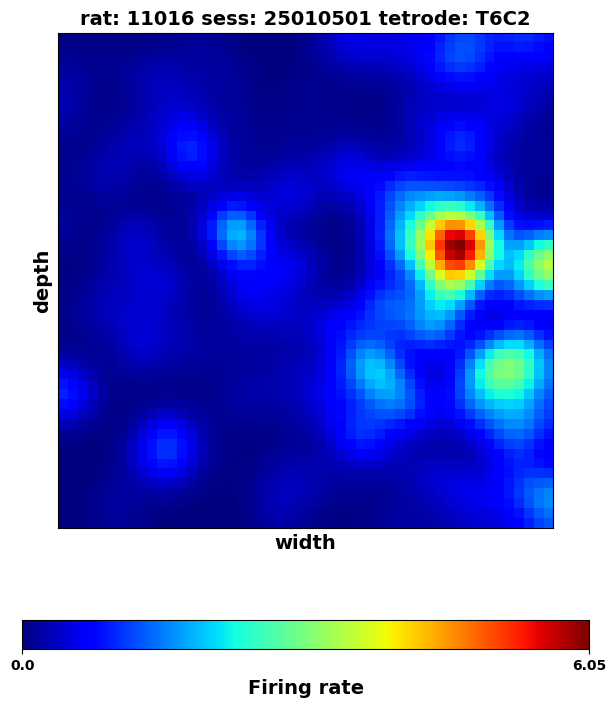

In [49]:
recoring_tetr_list = sargolini_data.plot_recording_tetr(recording_index=[1])


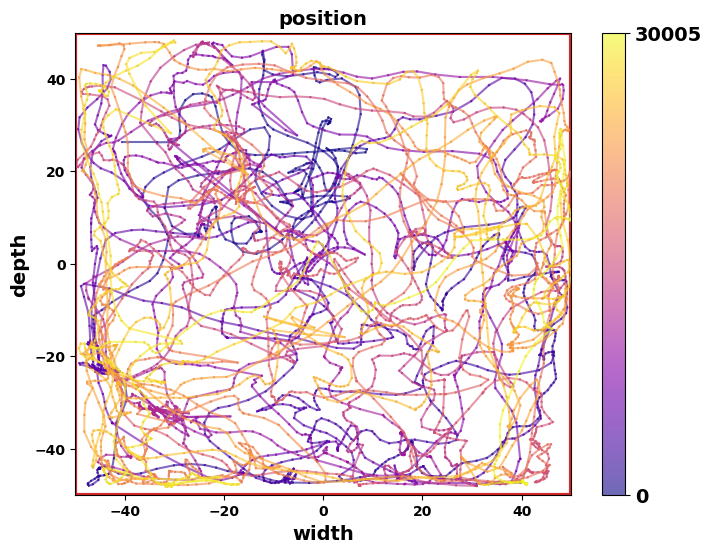

In [50]:
x, y, time_steps = sargolini_data.plot_trajectory(recording_index=2, plot_every=5,save_path ='./trajectory_2')
# Plot every 5 to make the plot lighter

Exercice: Do the thing bellow

X_mec shape: (20, 20)
X_mec shape: (20, 20)
X_mec shape: (20, 20)
X_mec shape: (20, 20)
X_mec shape: (20, 20)
X_mec shape: (400, 5)


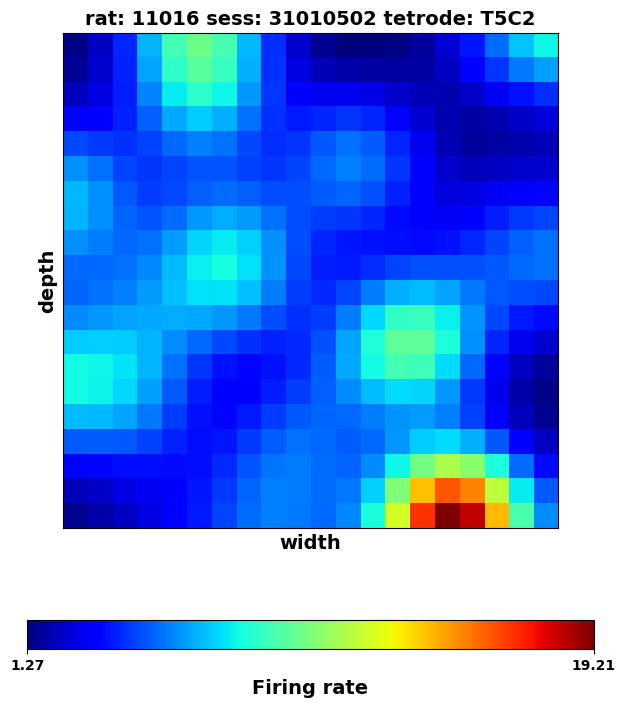

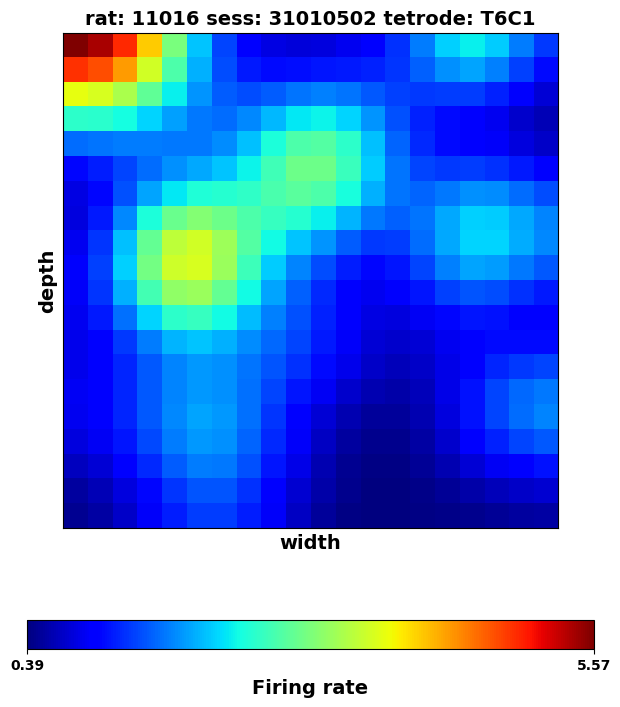

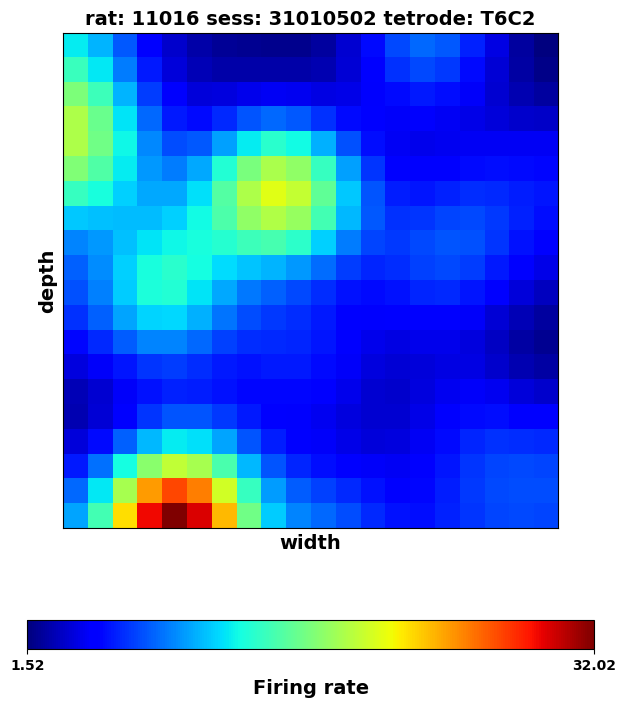

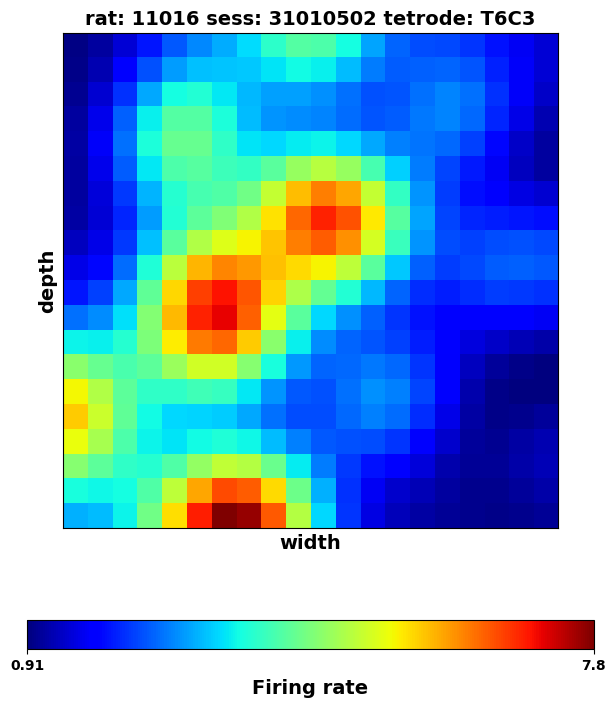

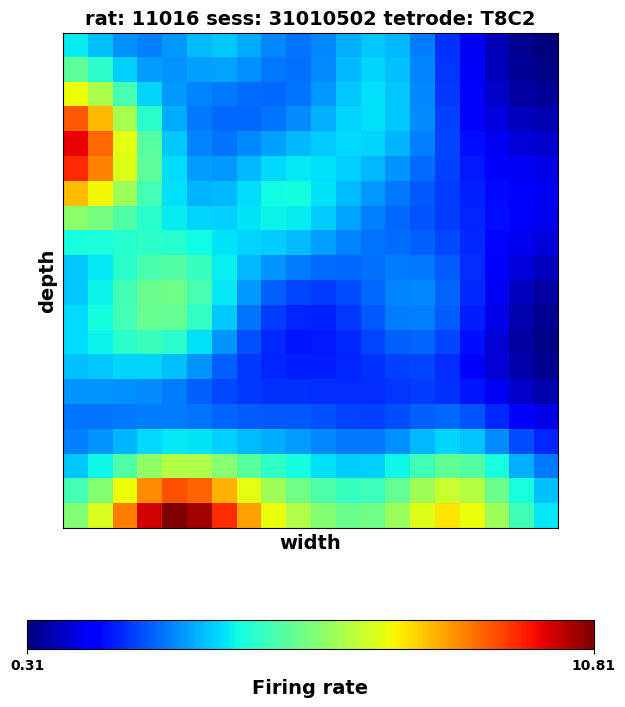

In [51]:
tetrode_ids = ["T5C2", "T6C1", "T6C2", "T6C3", "T8C2"]

# Arrays to store the output
rate_maps = []
x_bins = []
y_bins = []

# Loop over each tetrode ID and extract the data
for tet_id in tetrode_ids:
    rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(
        save_path='./trajectory_after_merge_2',
        recording_index=4,
        tetrode_id=tet_id,
        bin_size=5,
    )
    print("X_mec shape:", rate_map.shape)
    rate_maps.append(rate_map)
    x_bins.append(x_bin)
    y_bins.append(y_bin)

# Stack the flattened rate maps column-wise to form X_mec
#X_mec = np.stack(rate_maps, axis=2)  # Shape: (N_locations, N_mec_cells)
#print("X_mec shape:", X_mec.shape)  # Should be (N_locations, 5)
# Flatten each 2D rate map to a 1D array before stacking
rate_maps_flattened = [rate_map.flatten() for rate_map in rate_maps]

# Stack the flattened maps column-wise
X_mec = np.stack(rate_maps_flattened, axis=1)  # Shape: (2500, 5)

print("X_mec shape:", X_mec.shape)



## 2. Agent Training

### 🛠️ Virtual Arena from Experimental Data

The package includes tools for constructing flexible 2D environments with arbitrary geometries defined by "walls". These arenas can be easily adapted for different experimental setups.

We use metadata from real experiments to generate **virtual arenas** that accurately reflect the spatial structure and constraints of the original behavioral environments. This setup enables direct comparison between neural data and simulated agent activity.

This implementation includes simulations in environments modeled after the **Sargolini et al.** experiment, providing a practical way to test the SR model’s predictions in biologically realistic settings.

### 🧠 Running the Successor Representation (SR) Model

This module demonstrates how to train and evaluate an agent using the **Successor Representation (SR)** model, as described in:

**Kimberly L. Stachenfeld, Matthew M. Botvinick, & Samuel J. Gershman**
[*The hippocampus as a predictive map*, Nature Neuroscience (2017)](https://www.nature.com/articles/nn.4650)


The SR model proposes that the hippocampus encodes a predictive map of future states based on current location and transition dynamics.
Rather than representing space directly, the model encodes the expected future occupancy of states under a given policy. This allows for flexible, predictive spatial representations that support navigation and learning.

![Screenshot%202022-03-25%20at%2016.35.54.png](attachment:Screenshot%202022-03-25%20at%2016.35.54.png)




In [52]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:80% !important; }</style>"))

## Arenas with experimental data

These arenas are pre-configured to follow the dimensions and sampling rate of a real experiment. When initializing these arenas, the recorded data from the corresponding experiment will be automatically loaded using the Experimental Data Class (see [these examples](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/experimental_examples/experimental_data_examples.ipynb)). The idea is to create artificial environment with a structure that resembles the experiment, to then compare with experimental recordings. For now, these classes are

In [53]:
from neuralplayground.arenas import Sargolini2006

In [54]:
env_name = "Sargolini2006"
time_step_size = 0.1 #seg
agent_step_size = 5

env = Sargolini2006(environment_name = env_name,
                    time_step_size = time_step_size,
                    agent_step_size = agent_step_size,
                    use_behavioral_data = True)

Some of the methods from the Experiment class are included in these specific arena classes, these methods are ```show_data()```, ```set_animal_data()```, ```plot_recording_tetr()```, ```plot_recorded_trajectory()```. These methods works analogous to the ones available in the [Experiment classes](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/experimental_examples/experimental_data_examples.ipynb)

In [55]:
recording_list = env.show_data()  # env.data has an object of the experiment class with Sargolini et al data

Dataframe with recordings


,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


Dataframe with recordings


,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


(array([-11.33495021, -11.33495021, -12.81476112, ...,   2.96988862,
          3.70979408,   3.70979408]),
 array([-33.91940175, -33.91940175, -33.91940175, ...,   1.84269531,
          2.08933047,   2.08933047]),
 array([0.0000e+00, 2.0000e-02, 4.0000e-02, ..., 5.9994e+02, 5.9996e+02,
        5.9998e+02]))

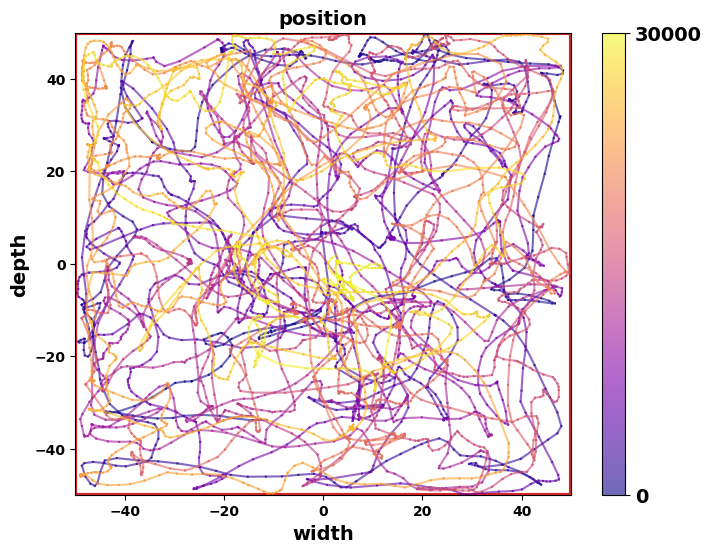

In [56]:
env.plot_recorded_trajectory(recording_index=3, plot_every=5)


You can set which recording behavior you want to use by using ```set_animal_data()``` methods as you would do with an experimental class


In [57]:
env.set_animal_data(recording_index=3)

### 🤖 Agent-Environment Interaction

The arenas are designed to support interaction with an agent using a similar method to the **OpenAI Gym** interface. The agent receives an observation, updates its representation and returns an action, which the environment uses to update its internal state.



In [58]:
import matplotlib.pyplot as plt
from neuralplayground.agents import Stachenfeld2018
from tqdm.notebook import tqdm


In [59]:
agent_step_size = 5
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)




## Eigenvector Selection and Projection

Here, we select a subset of grid cells and choose **5 eigenvectors** corresponding to the following eigenvalue indices:
**1, 10, 15, 20, and 25**.

We gather these cells into an array resulting in a matrix of shape: `(N_locations, N_eigvecs)`,

---
### Additional exercies:
For further analysis and comparison, you can modify the set of eigenvalues used and observe how this affects the resulting scores, or which eigenvector you choose.



<Axes: title={'center': 'Rate map: Eig10'}, xlabel='width', ylabel='depth'>

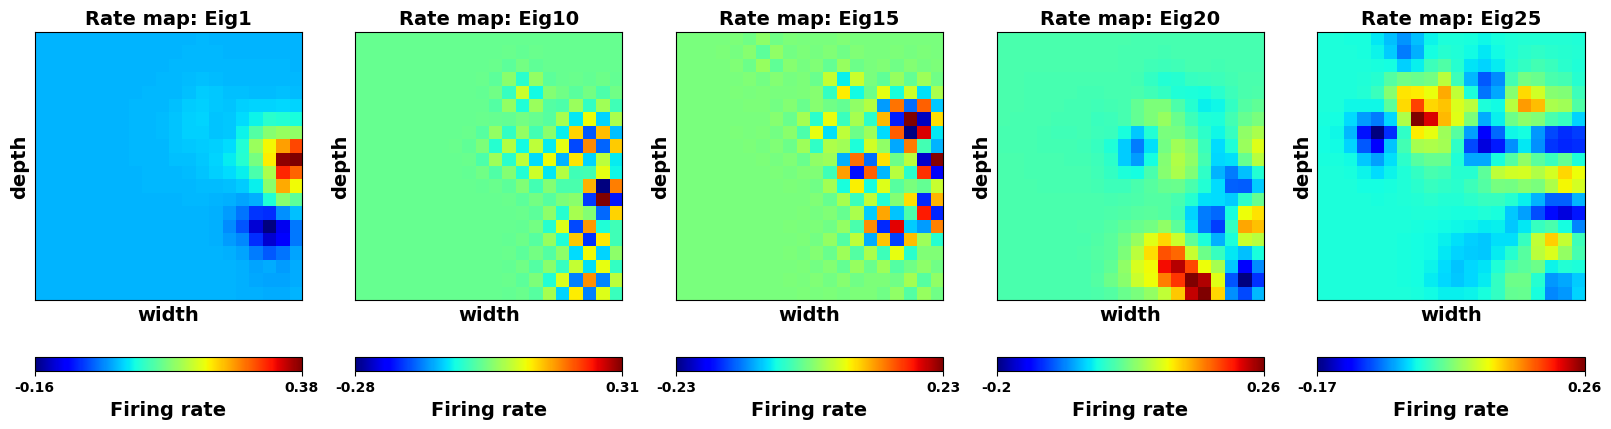

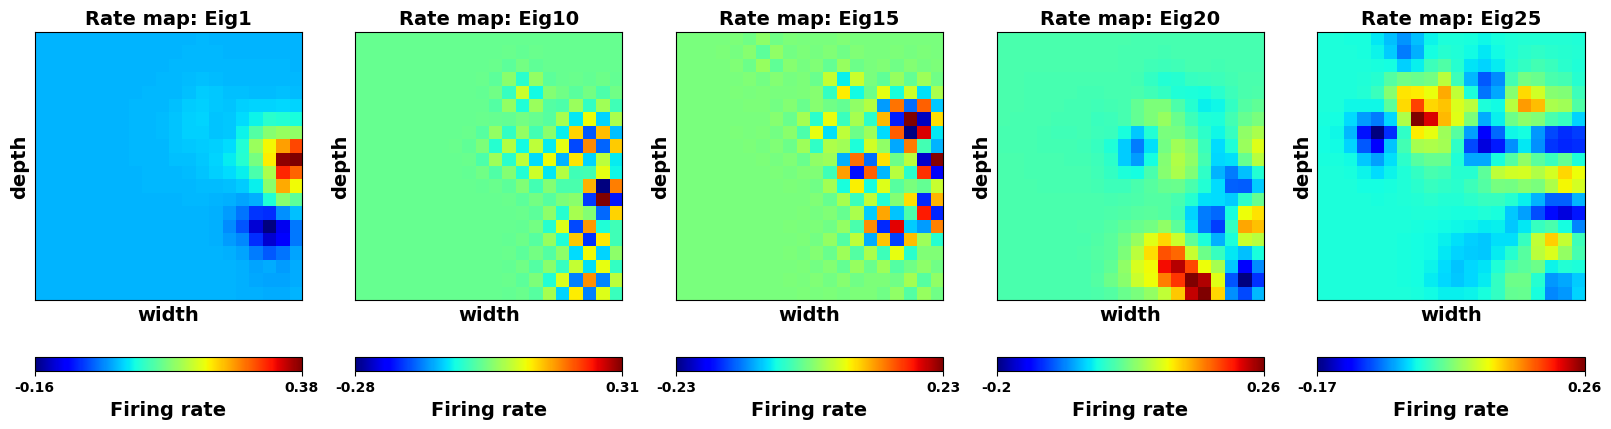

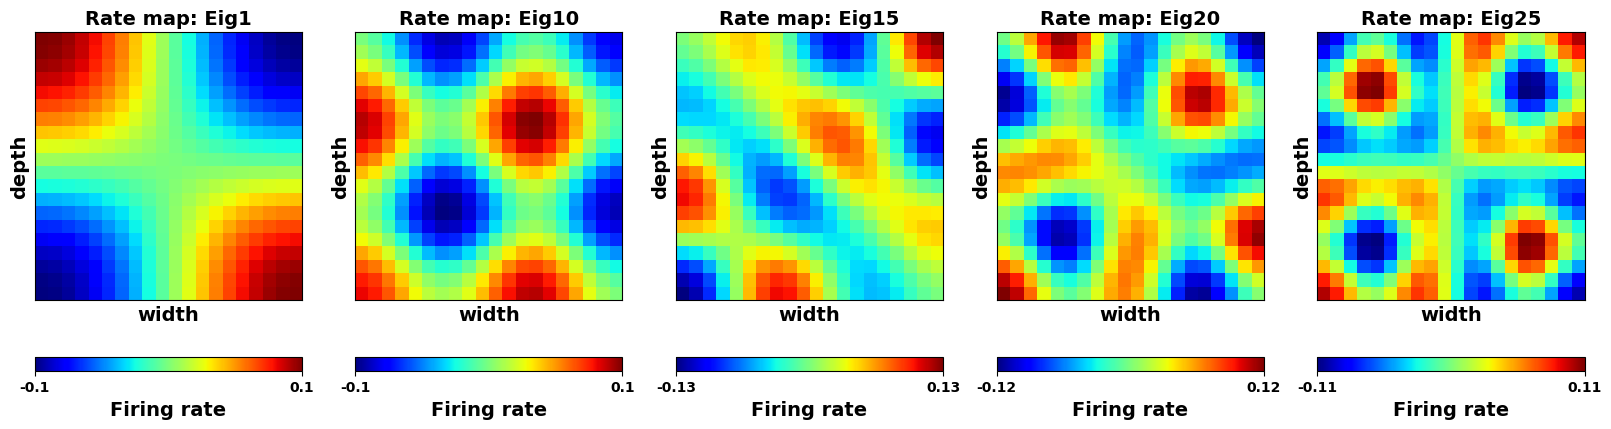

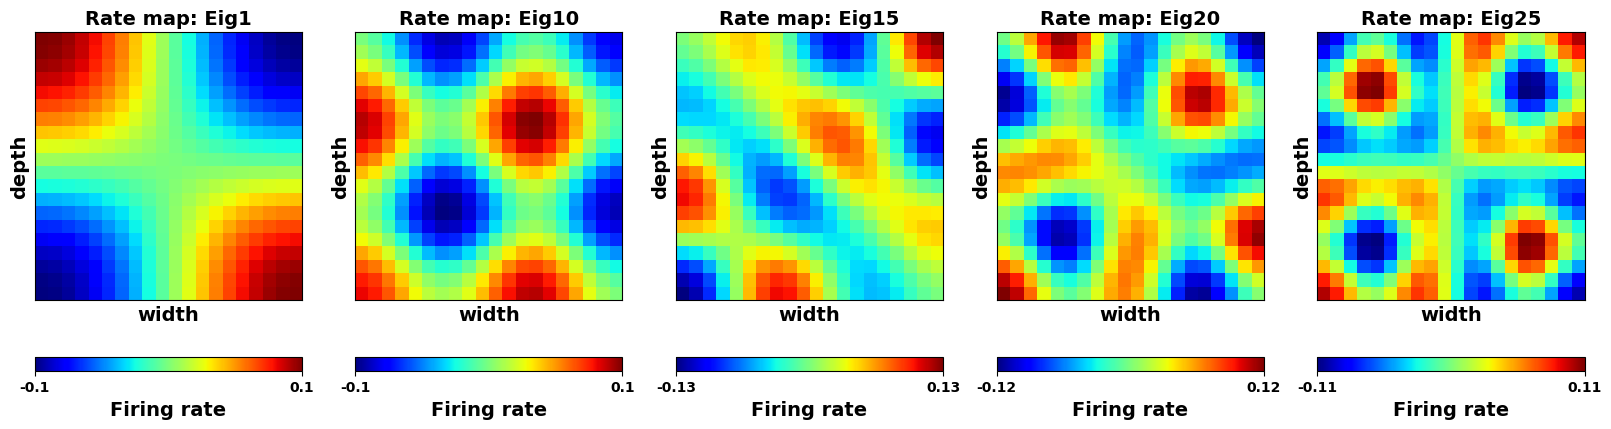

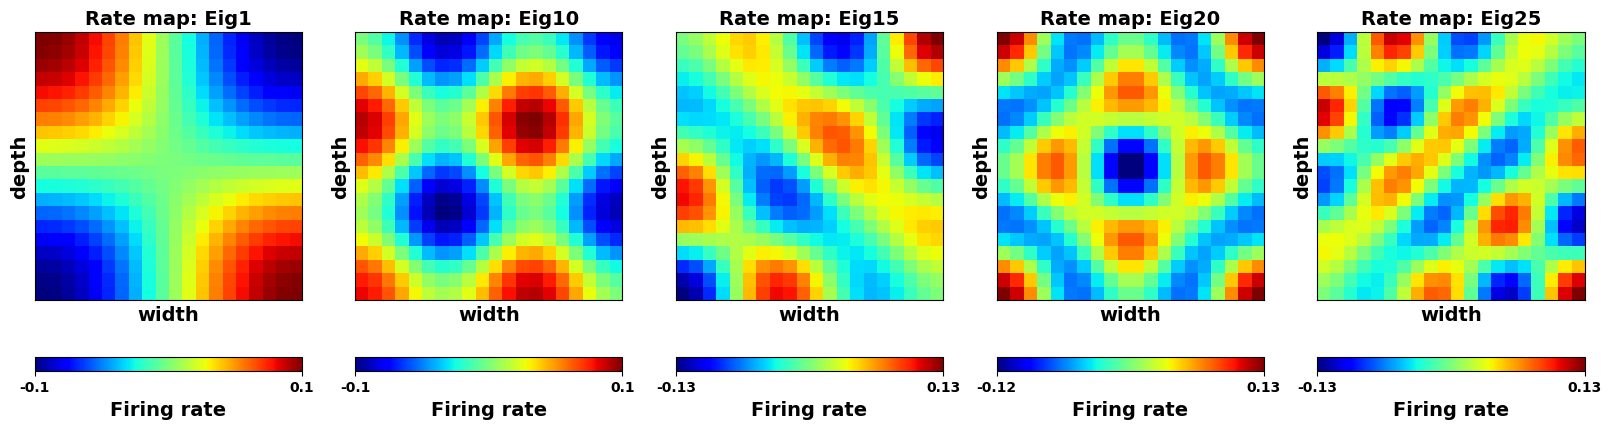

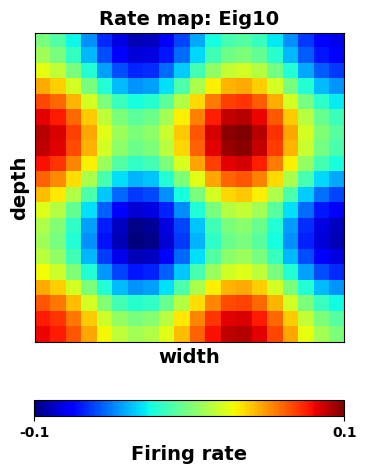

In [60]:
sr = agent.update_successor_rep_td_full(n_episode=100, t_episode=100) # One can compute the successor representation using successive additive update
agent.plot_rate_map(agent.srmat_full_td, eigen_vectors=[1,10,15,20,25],save_path=None)
agent.plot_rate_map(sr, eigen_vectors=[1,10,15,20,25],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_rate_map(agent.srmat_sum, eigen_vectors=[1,10,15,20,25],save_path=None)
agent.plot_rate_map(sr_sum, eigen_vectors=[1,10,15,20,25],save_path=None)


srmat_ground=agent.successor_rep_solution()
agent.plot_rate_map(agent.srmat_ground, eigen_vectors=[1,10,15,20,25],save_path=None)
agent.plot_rate_map(srmat_ground, eigen_vectors=10,save_path ='./grids_sr_2')

  0%|          | 0/1000000 [00:00<?, ?it/s]

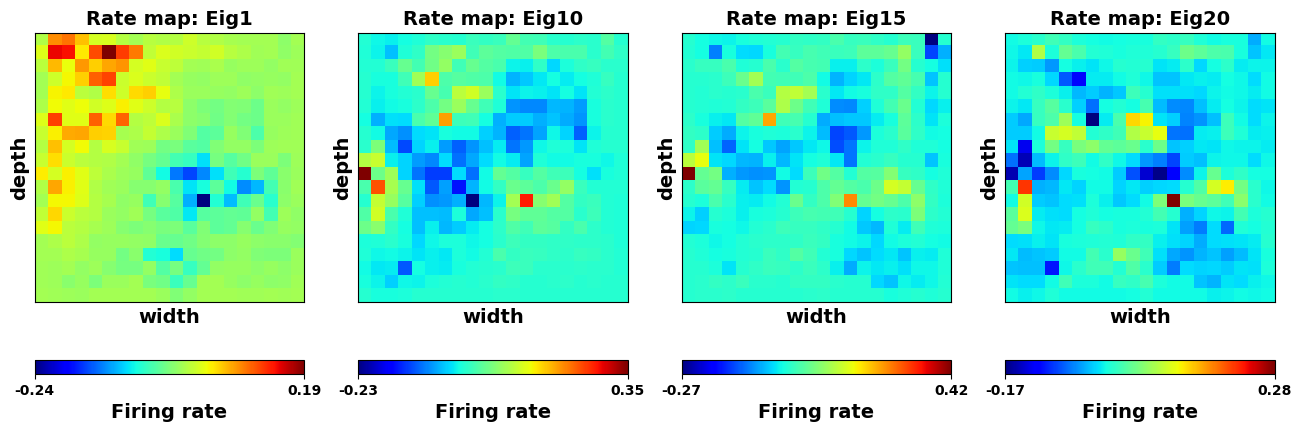

In [61]:
plot_every = 1000000
total_iters = 0
obs, state = env.reset()
for i in tqdm(range(1000000)):
# Observe to choose an action
    action = agent.act(obs[:2])  # the action is link to density of state to make sure we always land in a new
    agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Sargo.png')


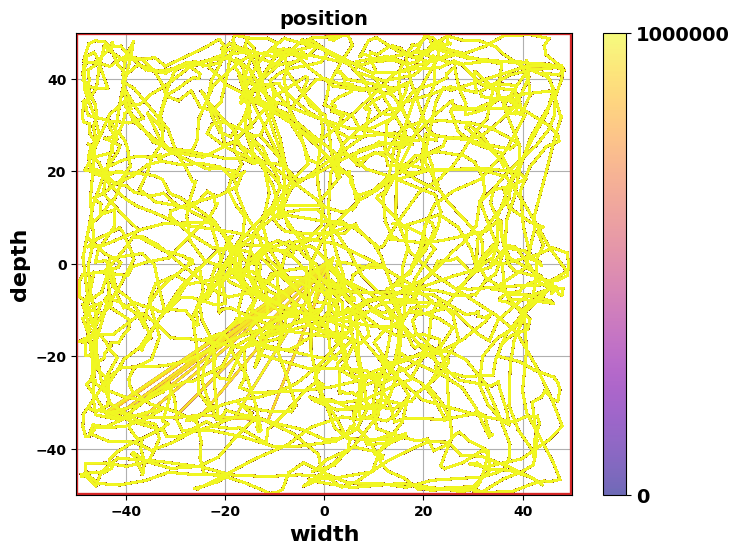

In [62]:
ax = env.plot_trajectory()
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
plt.savefig("sargolini.pdf", bbox_inches="tight")
plt.show()

In [83]:
Exercice: Do the thing bellow

SyntaxError: invalid syntax (3319777882.py, line 1)

In [84]:
# Plot every 5 to make the plot lighter
eigen_ids = [11,10,15,20,12]

# Arrays to store the output
rate_maps = []
x_bins = []
y_bins = []

# Loop over each tetrode ID and extract the data
for eigen_id in eigen_ids:
    rate_map = agent.get_rate_map_matrix(sr_matrix=agent.srmat_ground,eigen_vector=eigen_id)
    rate_maps.append(rate_map)
    print("X_sr shape:", rate_map.shape)
    x_bins.append(x_bin)
    y_bins.append(y_bin)

rate_maps_flattened = [rate_map.flatten() for rate_map in rate_maps]

# Stack the flattened rate maps column-wise to form X_sr
X_sr = np.stack(rate_maps_flattened, axis=1)  # Shape: (N_locations, N_mec_cells)

print("X_sr shape:", X_sr.shape)  # Should be (N_locations, 5)

X_sr shape: (20, 20)
X_sr shape: (20, 20)
X_sr shape: (20, 20)
X_sr shape: (20, 20)
X_sr shape: (20, 20)
X_sr shape: (400, 5)


### 3. Representation Comparison

### 🧠 What Neuroscientists Do in Practice

- **Compare statistical properties**, not direct alignments.
  - Grid score distributions
  - Field spacing
  - Orientation distributions
  - *Example*: “Do the model’s firing fields have similar spacing to real MEC data?”

- **Look at population-level decoding or geometry**
  - Latent space analysis (e.g., **toroidal topology** — *Gardner et al., 2022*)
  - Use manifold learning to compare qualitative structure

- **Qualitatively compare maps**
  - Visual inspection of rate maps and autocorrelograms
  - ❌ *But not actual 1:1 spatial alignments*


We have gathered the data and structured it in the following format:

```python
# X_mec: (N_locations, N_mec_cells)
# X_sr:  (N_locations, N_sr_features)
```

They are the same size now so it should be perfect to do the analysis




In [92]:
print("X_mec shape:", X_mec.shape)
print("X_mec shape:", X_sr.shape)

X_mec shape: (400, 5)
X_mec shape: (400, 5)


Procrustes Distance (Aligned):   50.4341
Procrustes Distance (Unaligned): 62.8425
Avg Cosine Similarity (Aligned):   0.3326
Avg Cosine Similarity (Unaligned): 0.0376


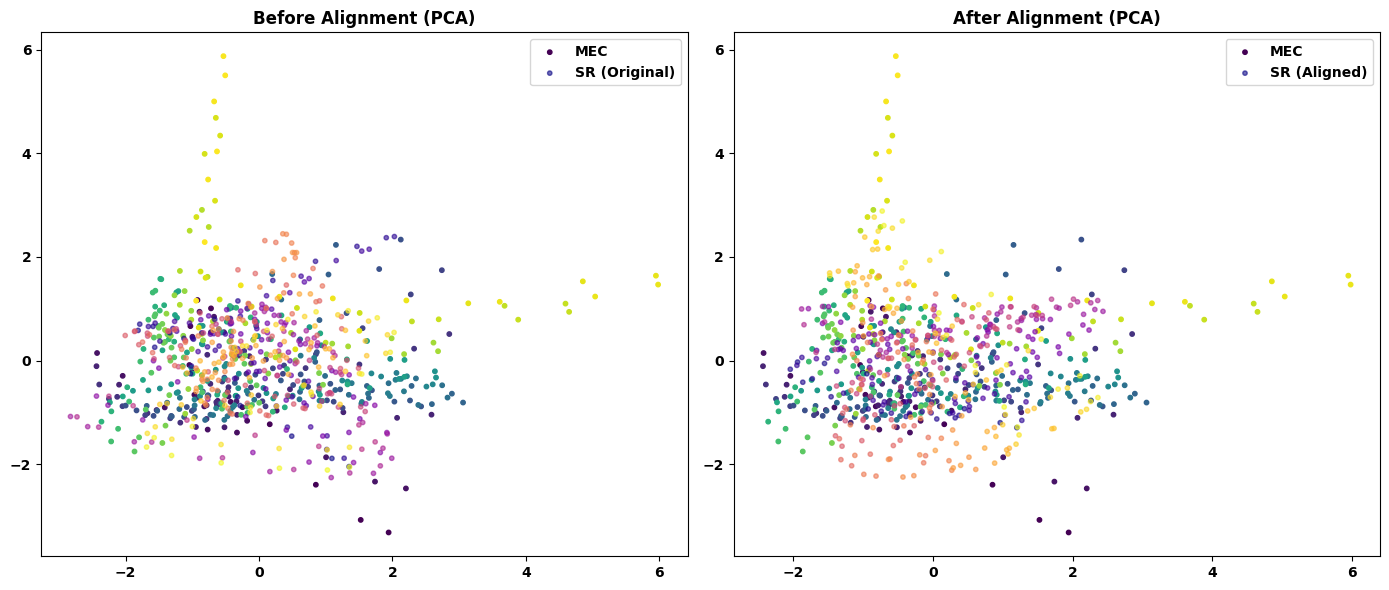

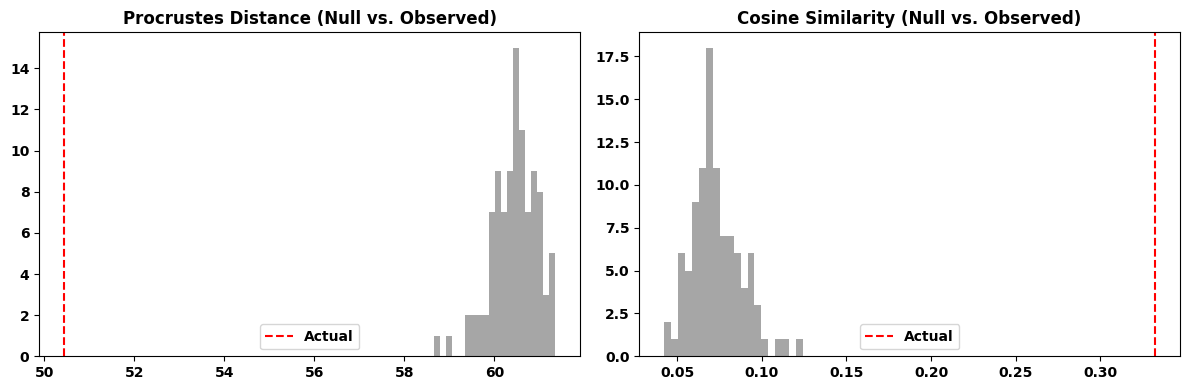

In [93]:
import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Load your data here ---
# X_mec and X_sr must be (N_locations, N_features)
# X_mec: real MEC data; X_sr: model representations (e.g., SR eigenvectors)

# --- Step 1: Preprocess (center & scale) ---
scaler_mec = StandardScaler()
X_mec_pre = scaler_mec.fit_transform(X_mec)

scaler_sr = StandardScaler()
X_sr_pre = scaler_sr.fit_transform(X_sr)

# --- Step 2: Procrustes Alignment (FIXED: removed extra scaling) ---
R, _ = orthogonal_procrustes(X_sr_pre, X_mec_pre)
X_sr_aligned = X_sr_pre @ R

# --- Step 3: Quantitative Metrics ---
def avg_cosine_sim(X1, X2):
    sims = [np.dot(X1[i], X2[i]) /
            (np.linalg.norm(X1[i]) * np.linalg.norm(X2[i]))
            for i in range(len(X1))]
    return np.nanmean(sims)

d_aligned = np.linalg.norm(X_mec_pre - X_sr_aligned, 'fro')
d_unaligned = np.linalg.norm(X_mec_pre - X_sr_pre, 'fro')
cos_sim_aligned = avg_cosine_sim(X_mec_pre, X_sr_aligned)
cos_sim_unaligned = avg_cosine_sim(X_mec_pre, X_sr_pre)

print(f"Procrustes Distance (Aligned):   {d_aligned:.4f}")
print(f"Procrustes Distance (Unaligned): {d_unaligned:.4f}")
print(f"Avg Cosine Similarity (Aligned):   {cos_sim_aligned:.4f}")
print(f"Avg Cosine Similarity (Unaligned): {cos_sim_unaligned:.4f}")

# --- Step 4: PCA-Based Visualization ---
pca = PCA(n_components=2)
pca_all = pca.fit(np.vstack([X_mec_pre, X_sr_pre, X_sr_aligned]))

X_mec_2d = pca_all.transform(X_mec_pre)
X_sr_2d = pca_all.transform(X_sr_pre)
X_sr_aligned_2d = pca_all.transform(X_sr_aligned)

spatial_color = np.linspace(0, 1, X_mec.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before alignment
axes[0].scatter(*X_mec_2d.T, c=spatial_color, cmap='viridis', s=10, label='MEC')
axes[0].scatter(*X_sr_2d.T, c=spatial_color, cmap='plasma', s=10, alpha=0.6, label='SR (Original)')
axes[0].set_title('Before Alignment (PCA)')
axes[0].legend()

# After alignment
axes[1].scatter(*X_mec_2d.T, c=spatial_color, cmap='viridis', s=10, label='MEC')
axes[1].scatter(*X_sr_aligned_2d.T, c=spatial_color, cmap='plasma', s=10, alpha=0.6, label='SR (Aligned)')
axes[1].set_title('After Alignment (PCA)')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Step 5: Random Baseline (Shuffle Test, FIXED) ---
n_shuffles = 100
shuffle_distances = []
shuffle_cosines = []

for i in range(n_shuffles):
    X_sr_shuffled = np.random.permutation(X_sr_pre)
    R_rand, _ = orthogonal_procrustes(X_sr_shuffled, X_mec_pre)
    X_sr_shuf_aligned = X_sr_shuffled @ R_rand

    d_rand = np.linalg.norm(X_mec_pre - X_sr_shuf_aligned, 'fro')
    cos_rand = avg_cosine_sim(X_mec_pre, X_sr_shuf_aligned)

    shuffle_distances.append(d_rand)
    shuffle_cosines.append(cos_rand)

# Plot the null distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(shuffle_distances, bins=20, color='gray', alpha=0.7)
axes[0].axvline(d_aligned, color='red', linestyle='--', label='Actual')
axes[0].set_title('Procrustes Distance (Null vs. Observed)')
axes[0].legend()

axes[1].hist(shuffle_cosines, bins=20, color='gray', alpha=0.7)
axes[1].axvline(cos_sim_aligned, color='red', linestyle='--', label='Actual')
axes[1].set_title('Cosine Similarity (Null vs. Observed)')
axes[1].legend()

plt.tight_layout()
plt.show()


In [100]:
from scipy.linalg import orthogonal_procrustes
from sklearn.preprocessing import StandardScaler


In [101]:
# --- Step 1: Preprocessing (Centering and Scaling) ---
# It's good practice to center and scale the data before Procrustes for consistency.
# This ensures that differences in mean activity or overall scale don't dominate the alignment.
scaler_mec = StandardScaler()
X_mec_preprocessed = scaler_mec.fit_transform(X_mec)

scaler_sr = StandardScaler()
X_sr_preprocessed = scaler_sr.fit_transform(X_sr)

In [102]:
# --- Step 2: Perform Procrustes Alignment ---
# orthogonal_procrustes(A, B) finds the optimal rotation R and scaling factor `scale`
# such that A @ R * scale is as close as possible to B.
# Here, we want to align SR to MEC, so SR is 'A' and MEC is 'B'.
R, scale = orthogonal_procrustes(X_sr_preprocessed, X_mec_preprocessed)

# Apply the transformation to the SR data
X_sr_aligned = np.dot(X_sr_preprocessed, R)


In [103]:
# --- Step 3: Calculate Quantitative Metrics ---
# Procrustes Distance (Frobenius norm of the difference)
procrustes_distance = np.linalg.norm(X_mec_preprocessed - X_sr_aligned, 'fro')
print(f"Procrustes Distance after alignment: {procrustes_distance:.4f}")

# Calculate distance *before* alignment for comparison
procrustes_distance_unaligned = np.linalg.norm(X_mec_preprocessed - X_sr_preprocessed, 'fro')
print(f"Procrustes Distance before alignment: {procrustes_distance_unaligned:.4f}")

# Average Cosine Similarity (aligned)
cosine_sim_per_location = [np.dot(X_mec_preprocessed[i], X_sr_aligned[i]) /
                           (np.linalg.norm(X_mec_preprocessed[i]) * np.linalg.norm(X_sr_aligned[i]))
                           for i in range(X_mec_preprocessed.shape[0])]
average_cosine_similarity = np.nanmean(cosine_sim_per_location) # Use nanmean to handle potential division by zero if a row is all zeros
print(f"Average Cosine Similarity (aligned): {average_cosine_similarity:.4f}")

# Average Cosine Similarity (unaligned)
cosine_sim_per_location_unaligned = [np.dot(X_mec_preprocessed[i], X_sr_preprocessed[i]) /
                                     (np.linalg.norm(X_mec_preprocessed[i]) * np.linalg.norm(X_sr_preprocessed[i]))
                                     for i in range(X_mec_preprocessed.shape[0])]
average_cosine_similarity_unaligned = np.nanmean(cosine_sim_per_location_unaligned)
print(f"Average Cosine Similarity (unaligned): {average_cosine_similarity_unaligned:.4f}")



Procrustes Distance after alignment: 50.4341
Procrustes Distance before alignment: 62.8425
Average Cosine Similarity (aligned): 0.3326
Average Cosine Similarity (unaligned): 0.0376


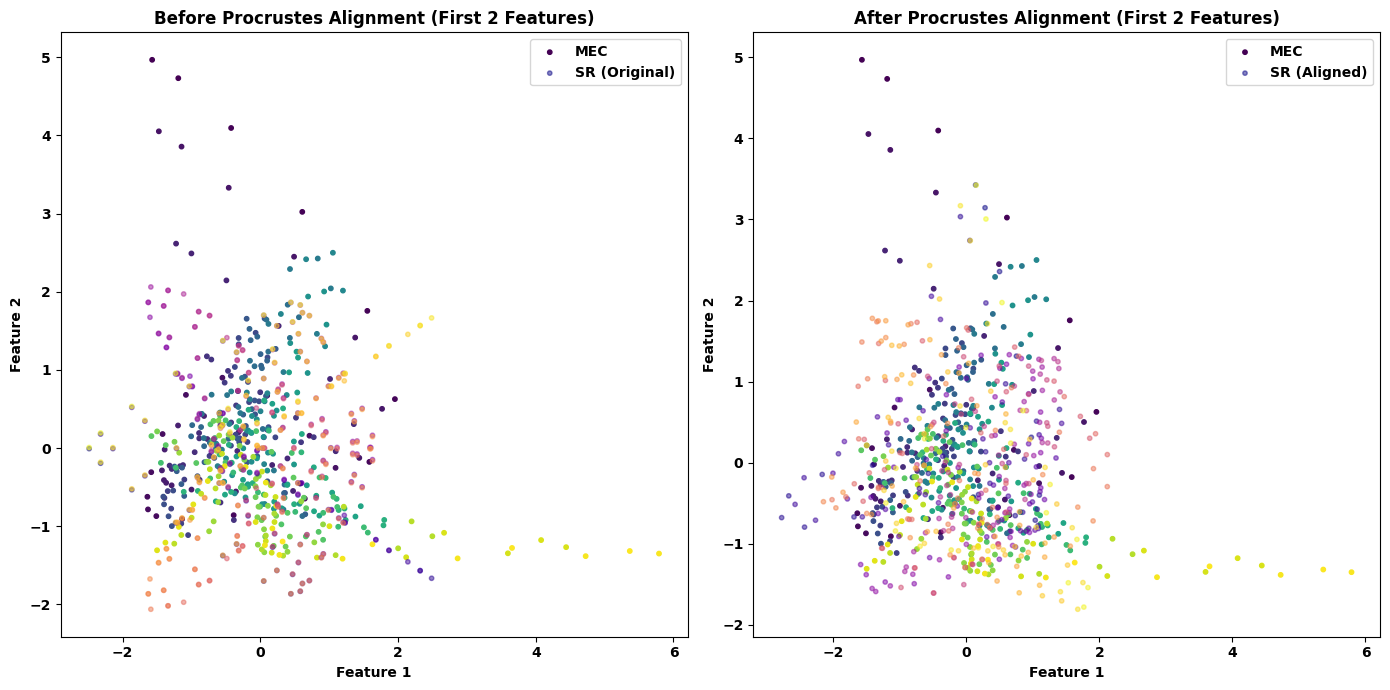

In [104]:
# --- Step 4: Visualization (using the first 2 or 3 dimensions) ---
# Even though you have 10 dimensions, you'll still visualize in 2D or 3D for clarity.
# You can either use the first 2/3 of the 10 dimensions directly, or run PCA on the 10 dimensions
# for visualization purposes if you want to find the directions of maximal variance within those 10.
# For simplicity, let's just plot the first two dimensions of the preprocessed data.

# Assuming you have `locations` array (N_locations, 2) for coloring
# Let's use the x-coordinate of the location for coloring as an example.
# Replace with your actual spatial variable for coloring.
# For demonstration, let's create a dummy spatial_variable_for_color
N_locations = X_mec.shape[0]
spatial_variable_for_color = np.linspace(0, 1, N_locations) # Example: just a gradient

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Before alignment
axes[0].scatter(X_mec_preprocessed[:, 0], X_mec_preprocessed[:, 1], c=spatial_variable_for_color, cmap='viridis', s=10, label='MEC')
axes[0].scatter(X_sr_preprocessed[:, 0], X_sr_preprocessed[:, 1], c=spatial_variable_for_color, cmap='plasma', s=10, alpha=0.5, label='SR (Original)')
axes[0].set_title('Before Procrustes Alignment (First 2 Features)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()

# After alignment
axes[1].scatter(X_mec_preprocessed[:, 0], X_mec_preprocessed[:, 1], c=spatial_variable_for_color, cmap='viridis', s=10, label='MEC')
axes[1].scatter(X_sr_aligned[:, 0], X_sr_aligned[:, 1], c=spatial_variable_for_color, cmap='plasma', s=10, alpha=0.5, label='SR (Aligned)')
axes[1].set_title('After Procrustes Alignment (First 2 Features)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

plt.tight_layout()
plt.show()

In [105]:

# --- Step 5: Random Baselines (as discussed previously) ---
# This step is still crucial to determine if your alignment is statistically significant.
# The code for this remains the same as provided in the detailed plan.

In [107]:
Some question : shoudl I compare this to have th

SyntaxError: invalid syntax (2313800760.py, line 1)

In [70]:
gent.srmat_ground